Mimicking the [work](https://www.kaggle.com/ivankontic/003-2-kmeans-and-gmm-feature-extraction-tps-aug) of last month winner @ivankontic for Sepetember dataset.

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imread

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import scipy.stats as stats

import lightgbm as lgb
import warnings

In [3]:
R_SEED = 2017

In [4]:
submit = False # for some testing

In [5]:
submission_ex = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2021/sample_solution.csv')
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2021/train.csv')
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2021/test.csv')

### Main idea
If we merge train data with test data and perform series of transformation on them, maybe we create additional bond between them. Just an idea, let's see what will happen.

In [6]:
targets_df = train_df[['claim']].copy()
train_df.drop(['id', 'claim'], axis=1, inplace=True) 
test_df.drop(['id'], axis=1, inplace=True) 

In [7]:
train_df = train_df.fillna(train_df.median())
test_df = test_df.fillna(test_df.median())

In [8]:
all_df = pd.concat([train_df, test_df])
# 1-------------------vvv

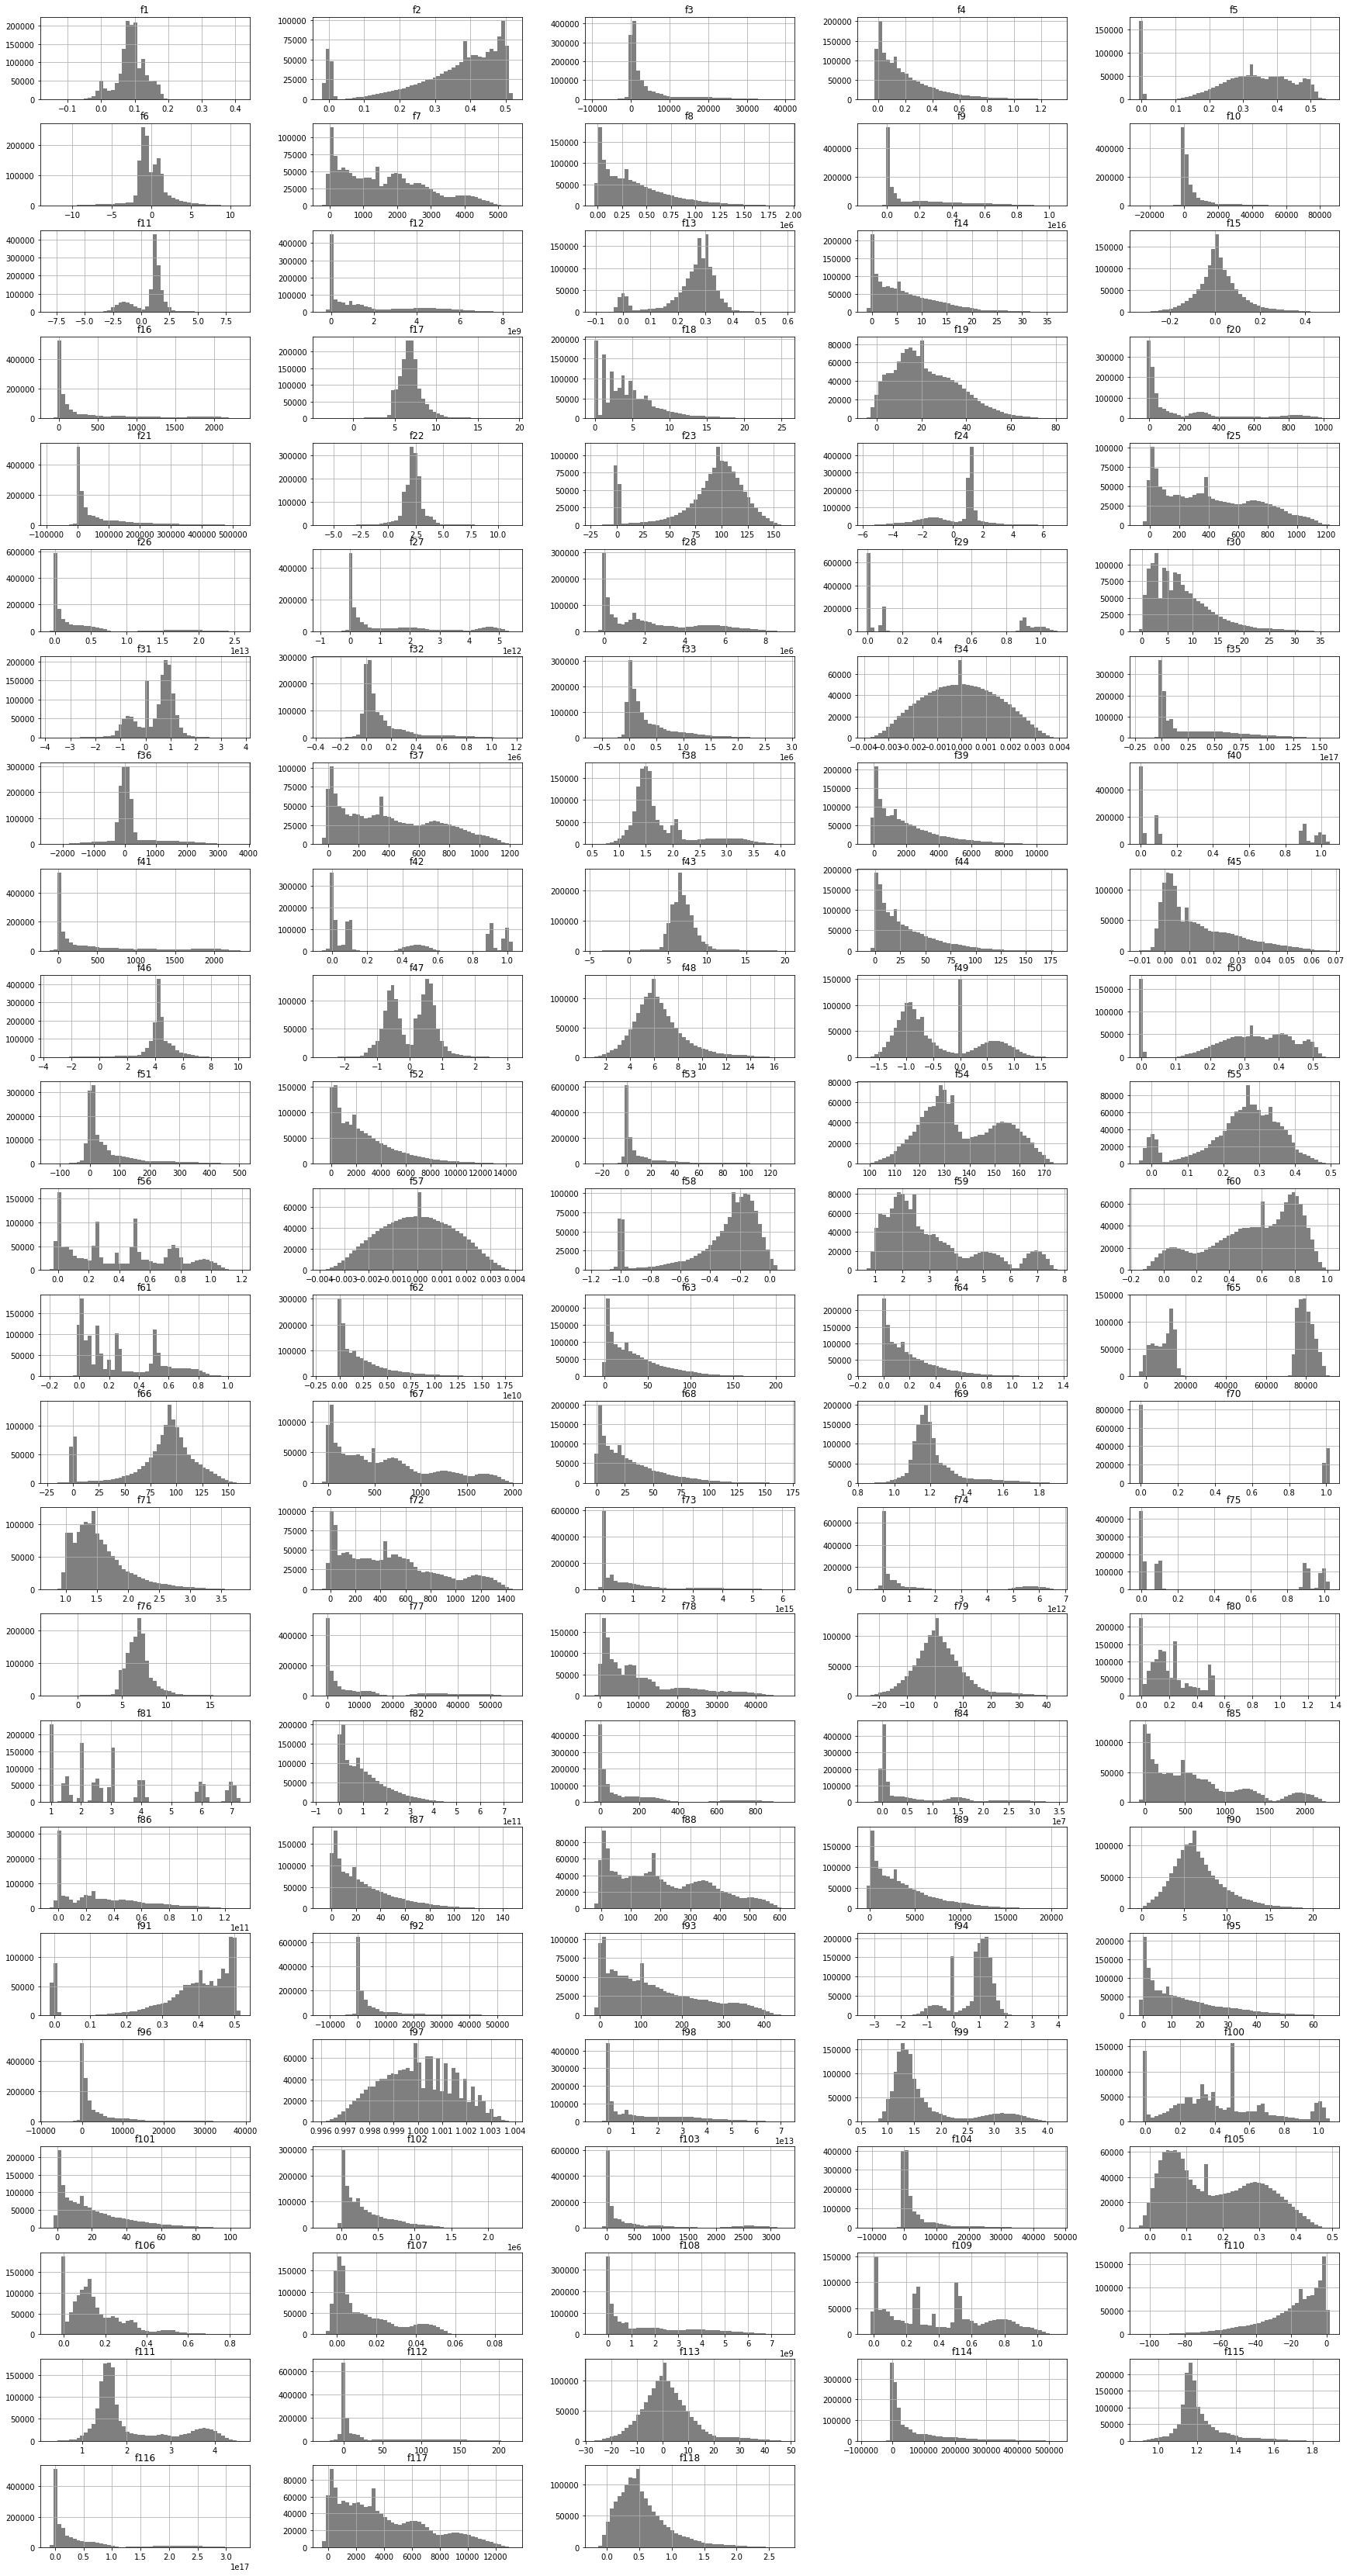

In [9]:
warnings.filterwarnings("ignore")

fig = plt.figure(figsize = (30,60))
ax = fig.gca()
hist = all_df.hist(bins = 50, layout = (24,5), color='k', alpha=0.5,  ax = ax)

#### step by step
I know that kmeans is not very good for this, but, its fast enough for just a try.

In [10]:
# warnings.filterwarnings("ignore")
def plot_fea_hist(fea_name):
    fig = plt.figure(figsize = (10, 10))
    ax = fig.gca()
    hist = all_df[fea_name].hist(bins=150, ax = ax)

#### KMeans

In [11]:
def plot_kmeans(data, labels, no_of_cl, fea_name, ax):
    ax.hist(data, 100, density = True)
    for cl in range(no_of_cl):
        ax.hist(data[labels == cl], 1, density = True, alpha = 0.5)
    ax.set_title(fea_name)
#     plt.show()

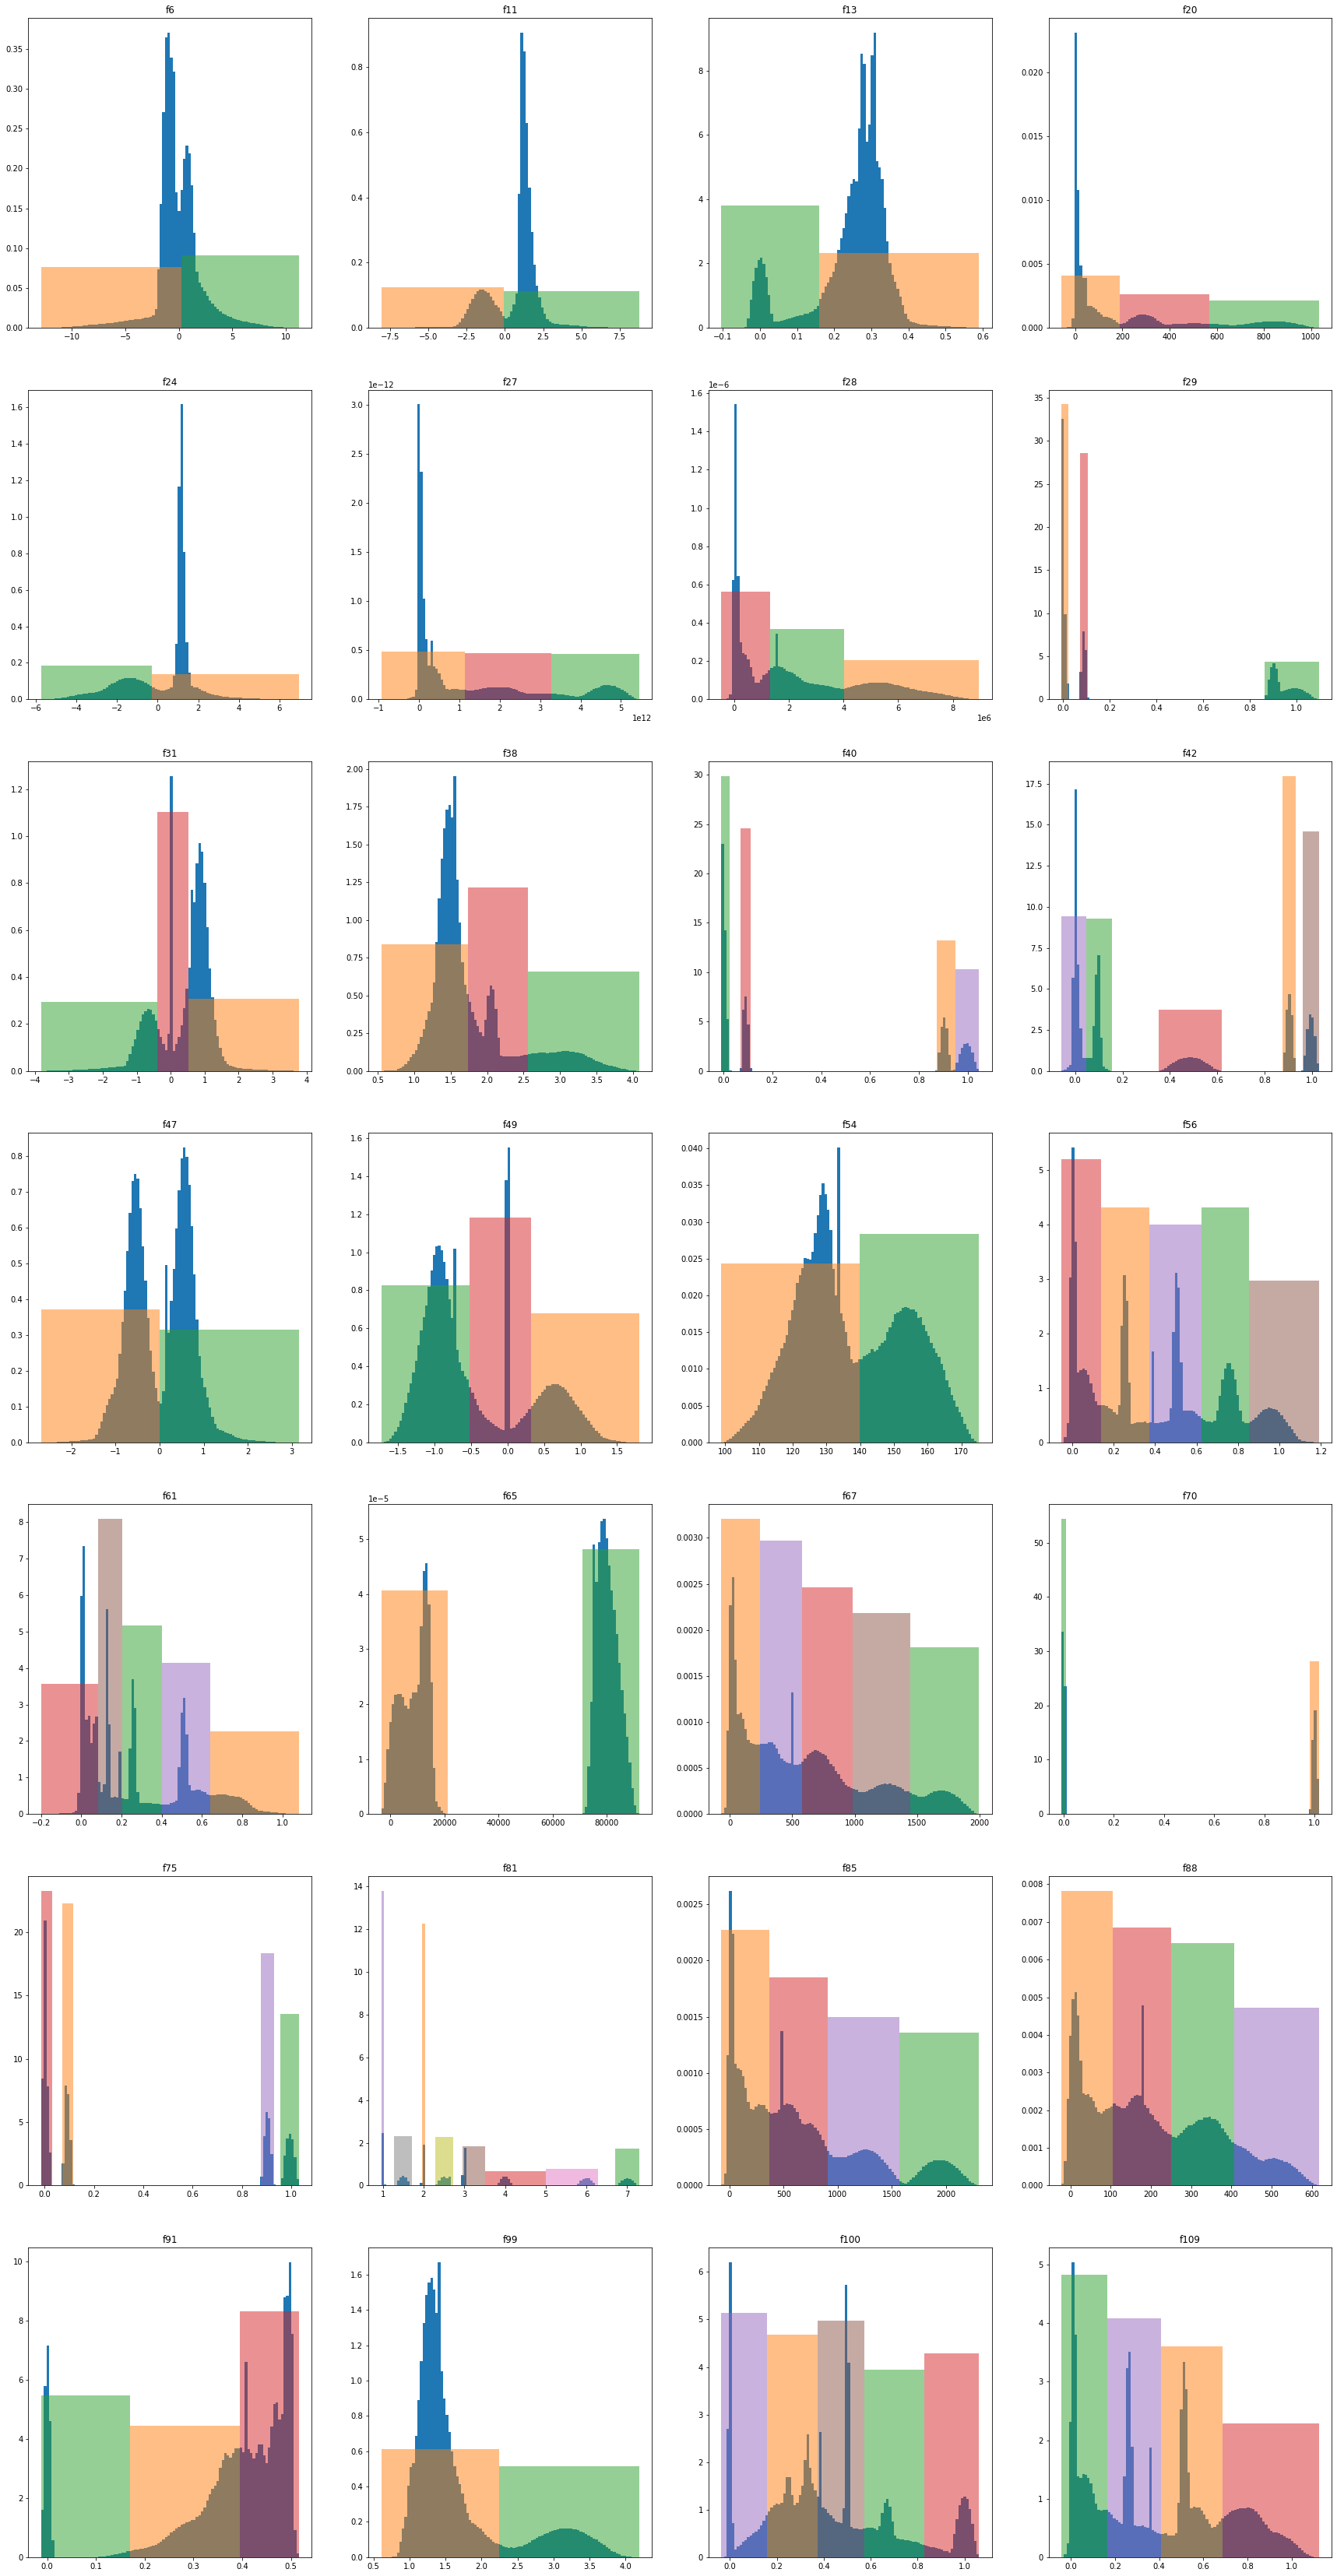

In [12]:
# guesswork
for_kmeans = [('f6', 2), ('f11', 2), ('f13', 2), ('f20', 3), ('f24', 2), ('f27', 3), ('f28', 3), ('f29', 3), ('f31', 3), 
              ('f38', 3), ('f40', 4), ('f42', 5), ('f47', 2), ('f49', 3), ('f54', 2), ('f56', 5), ('f61', 5), ('f65', 2), 
              ('f67', 5), ('f70', 2), ('f75', 4), ('f81', 8), ('f85', 4), ('f88', 4), ('f91', 3),  
              ('f99', 2), ('f100', 5), ('f109', 4)]

fig, axes = plt.subplots(nrows = 7, ncols = 4, figsize=(30, 60))
i = 1
for f, n_clusters in for_kmeans:
#     print(str(i) + ' of ' + str(len(for_kmeans)))
    
    # KMeans
    data = all_df[[f]].values
    km = KMeans(n_clusters = n_clusters, n_init = 50)
    km.fit(data)
    k_clus = km.labels_
    
    # print(km.cluster_centers_)
    # print(pd.value_counts(km.labels_))

    ax = axes[(i-1) // 4, (i-1) % 4]
    plot_kmeans(data, k_clus, n_clusters, f, ax)

    i += 1
    
    # # one_h_clus = np.zeros((k_clus.size, k_clus.max()+1))
    # # one_h_clus[np.arange(k_clus.size), k_clus] = 1
    # # for i in range(n_clusters):
    # #     all_df['clus_' + str(i)] = one_h_clus[:,i]

#     all_df[f + '_clus'] = k_clus
    _dist = km.transform(data)
    _dict = {f + '_dist_from_' + str(i): _dist[:,i] for i in range(n_clusters)}
    for k, v in _dict.items():
        all_df[k] = v
#     del all_df[f]
plt.show()

I created some new features as distance from cluster centroids for specified original features.

#### GaussianMixture

In [13]:
def plot_gmm(model, data, fea_name, ax):
    weights = model.weights_
    means = model.means_
    covars = model.covariances_

    n, bins, patches = ax.hist(data, 100, density = True, alpha = 0.2, color = 'k')
    x = np.arange(np.min(data), np.max(data), (np.max(data) - np.min(data)) / 100)
    for i in range(len(weights)):
        ax.plot(x, weights[i] * stats.norm.pdf(x,means[i],np.sqrt(covars[i])[0]), alpha = 0.7, linewidth = 3)
    ax.set_title(fea_name)
#     plt.show()

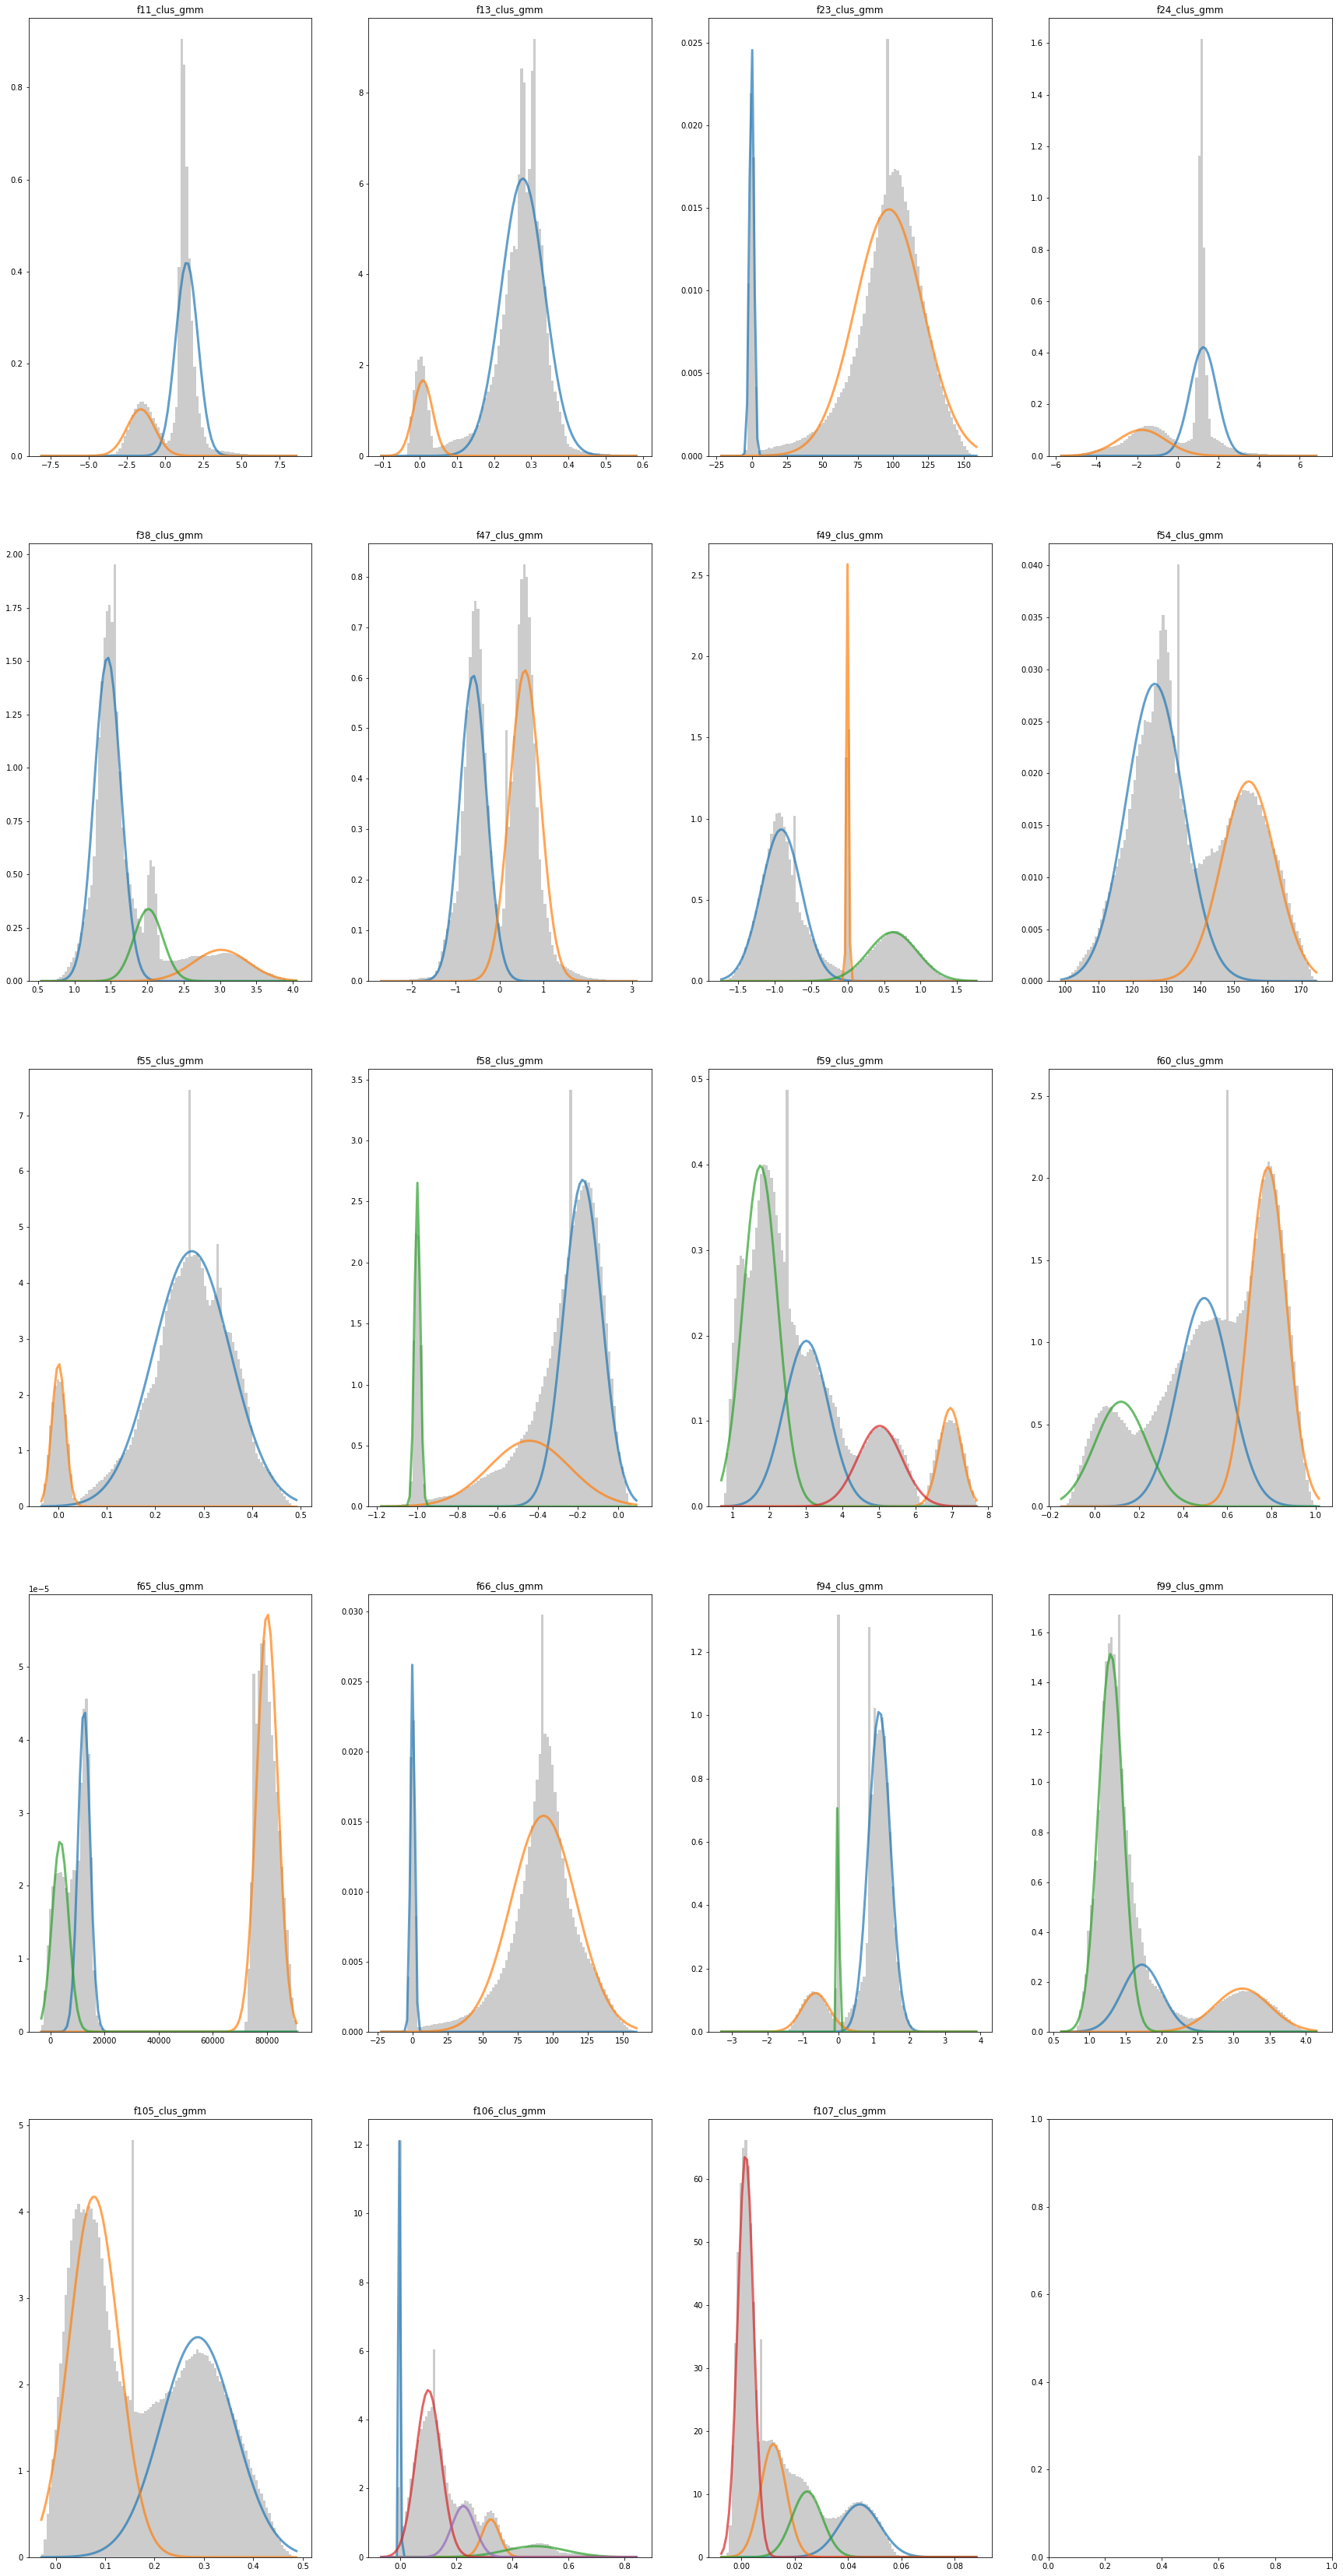

In [14]:
# guesswork
for_gmm = [('f11', 2), ('f13', 2), ('f23', 2), ('f24', 2), ('f38', 3), ('f47', 2), ('f49', 3),
           ('f54', 2), ('f55', 2), ('f58', 3), ('f59', 4), ('f60', 3), ('f65', 3), ('f66', 2), ('f94', 3), ('f99', 3), 
           ('f105', 2), ('f106', 5), ('f107', 4)]

fig, axes = plt.subplots(nrows = 5, ncols = 4, figsize=(30, 60))

i = 1
for f, n_clusters in for_gmm:
#     print(str(i) + ' of ' + str(len(for_gmm)))
    
    # GMM
    data = all_df[[f]].values
    
    gm = GaussianMixture(n_components = n_clusters, n_init = 50)
    gm.fit(data)
    k_clus_1 = gm.predict(data)
    k_clus_2 = gm.predict_proba(data)

    ax = axes[(i-1) // 4, (i-1) % 4]
    plot_gmm(gm, data, f + '_clus_gmm', ax)
    i += 1
    
    all_df[f + '_clus_gmm'] = k_clus_1
    for j in range(len(k_clus_2[0])):
        all_df[f + '_clus_gmm_' + str(j)] = k_clus_2[:, j]

plt.show()

gmm features represent probability that value of original feature belongs to certain distribution

In [15]:
all_df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f106_clus_gmm_0,f106_clus_gmm_1,f106_clus_gmm_2,f106_clus_gmm_3,f106_clus_gmm_4,f107_clus_gmm,f107_clus_gmm_0,f107_clus_gmm_1,f107_clus_gmm_2,f107_clus_gmm_3
0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,...,0.000000e+00,1.039781e-12,0.000137,0.997229,0.002633,3,1.285576e-08,2.103736e-02,0.000032,9.789306e-01
1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,...,0.000000e+00,1.991801e-08,0.000799,0.936184,0.063018,0,9.998633e-01,1.855222e-13,0.000137,3.572597e-56
2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,...,9.915554e-38,9.527310e-20,0.000046,0.999936,0.000018,3,1.958819e-08,2.714364e-02,0.000048,9.728082e-01
3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,...,0.000000e+00,1.188131e-02,0.015598,0.036402,0.936119,3,1.886879e-09,7.228331e-03,0.000005,9.927670e-01
4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,...,0.000000e+00,1.378410e-08,0.000736,0.943291,0.055973,3,2.948724e-08,3.486327e-02,0.000071,9.650656e-01


In [16]:
all_df.columns.values

array(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11',
       'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20',
       'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29',
       'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38',
       'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47',
       'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56',
       'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65',
       'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74',
       'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83',
       'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92',
       'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101',
       'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109',
       'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117',
       'f118', 'f6_dist_from_0', 'f6_dist_from_1', 'f11_dist_from_0',
       'f11

In [17]:
# 1-------------------^^^
train_df, test_df = all_df.iloc[:train_df.shape[0],:].copy(), all_df.iloc[-test_df.shape[0]:,:].copy()

In [18]:
train_df.to_csv("trainfeat.csv", index=False)
test_df.to_csv("testfeat.csv", index=False)